In [4]:
import torch.nn as nn
import torch
import torch.autograd as ag
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
data_set = pd.read_csv("Concrete Compressive Strength.csv")

# Extract water-cement ratio and compressive strength
wc = data_set.iloc[:, -1]  # water cement ratio
wc = torch.tensor(wc.values, dtype=torch.float32).to(device)
cs = data_set.iloc[:, -2]  # Compressive Strength (MPa)
cs = torch.tensor(cs.values, dtype=torch.float32).to(device)
wc = wc.reshape(-1, 1)
cs = cs.reshape(-1, 1)

# Low-fidelity (LF) data - Add noise
eqn_lf = 1000 / (3.5 * wc)  # just an example
cs_lf = eqn_lf + 0.05 * torch.randn_like(eqn_lf)

# Create custom W/C ranges for more data in specific regions
wc_lower = torch.linspace(0.225, 0.275, 5000).reshape(-1, 1)   # More points below 0.275
wc_middle = torch.linspace(0.35, 0.5, 10000).reshape(-1, 1)     # More points in middle region
wc_upper = torch.linspace(0.6, 0.9, 5000).reshape(-1, 1)       # More points above 0.6

# Combine custom W/C values
wc_custom = torch.cat((wc_lower, wc_middle, wc_upper), dim=0)

# Apply low-fidelity equation to the new points
eqn_lf_custom = 1000 / (3.5 ** wc_custom)
cs_lf_custom = eqn_lf_custom + 0.05 * torch.randn_like(eqn_lf_custom)

# Combine all low-fidelity data
wc_combined = torch.cat((wc, wc_custom), dim=0)
cs_lf_combined = torch.cat((cs_lf, cs_lf_custom), dim=0)

# Set up inputs for training/evaluation
X_input = wc

# Create physics-based evaluation points
wc_physics = torch.linspace(0.225, 0.9, 100, requires_grad=True, device=device, dtype=torch.float32).reshape(-1, 1)
X_physics = wc_physics


In [6]:
# We consider Net as our Model

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.hidden_layer1 = nn.Linear(1,32)
        self.hidden_layer2 = nn.Linear(32,32)
        self.hidden_layer3 = nn.Linear(32,32)
        self.hidden_layer4 = nn.Linear(32,32)
        self.hidden_layer5 = nn.Linear(32,32)
        self.output_layer = nn.Linear(32,1)

        self.act = nn.LeakyReLU()
        self.drop = nn.Dropout(0.4)
    def forward(self, x):

        layer1_out = self.drop(self.act(self.hidden_layer1(x)))
        layer2_out = self.drop(self.act(self.hidden_layer2(layer1_out)))
        layer3_out = self.drop(self.act(self.hidden_layer3(layer2_out)))
        layer4_out = self.drop(self.act(self.hidden_layer4(layer3_out)))
        layer5_out = self.drop(self.act(self.hidden_layer5(layer4_out)))
        output = self.output_layer(layer5_out)
        return output

class LowFidelityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = model()

    def forward(self, x):
        return self.net(x)

class CorrectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = model()

    def forward(self, x):
        return self.net(x)

# Combined HF model
def combined_model(x, lf_model, correction_model):
    return lf_model(x) + correction_model(x)

In [7]:
# Loss functions
def lf_loss(lf_model, X_lf, Y_lf):
    return mse_cost_function(lf_model(X_lf), Y_lf)

def hf_loss(lf_model, corr_model, X_hf, Y_hf):
    preds = combined_model(X_hf, lf_model, corr_model)
    return mse_cost_function(preds, Y_hf)

def f(X_Physics, net_corr):
    # optionally apply correction model only to physics loss
    u_corr = net_corr(X_Physics).squeeze()
    wc = X_Physics
    eqn = 984 / (4 ** wc)
    pde = eqn - u_corr
    return torch.mean(pde)

In [8]:
### (2) Model
net_lf = model().to(device)
net_corr = model().to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
LR = 1e-4
params = list(net_lf.parameters()) + list(net_corr.parameters())
optimizer = torch.optim.Adam(params, lr=LR)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=.1)



In [9]:
epochs = 6000
for i in range(epochs):
    optimizer.zero_grad()

    # Low-fidelity data loss
    output_lf = net_lf(X_input)
    loss_lf = mse_cost_function(output_lf, cs_lf)

    # High-fidelity data loss using combined model
    output_hf = output_lf + net_corr(X_input)
    loss_hf = mse_cost_function(output_hf, cs)

    # Physics-informed loss (correction model only)
    pde_loss = f(X_physics, net_corr)

    # Total loss (weighted sum if desired)
    loss = 0.15 * loss_lf + loss_hf * 0.4 + pde_loss * 0.45

    loss.backward()
    optimizer.step()

    if i % 500 == 0:
        print(f"Epoch {i}, Total Loss: {loss.item():.6f}")

Epoch 0, Total Loss: 70165.453125
Epoch 500, Total Loss: 57039.839844
Epoch 1000, Total Loss: 42375.773438
Epoch 1500, Total Loss: 34612.039062
Epoch 2000, Total Loss: 34801.945312
Epoch 2500, Total Loss: 32495.582031
Epoch 3000, Total Loss: 32114.753906
Epoch 3500, Total Loss: 28594.302734
Epoch 4000, Total Loss: 28937.619141
Epoch 4500, Total Loss: 26650.173828
Epoch 5000, Total Loss: 27465.921875
Epoch 5500, Total Loss: 25910.919922


In [10]:
# Save Model
torch.save(net_lf.state_dict(), "model_lf.pt")
torch.save(net_corr.state_dict(), "model_corr.pt")

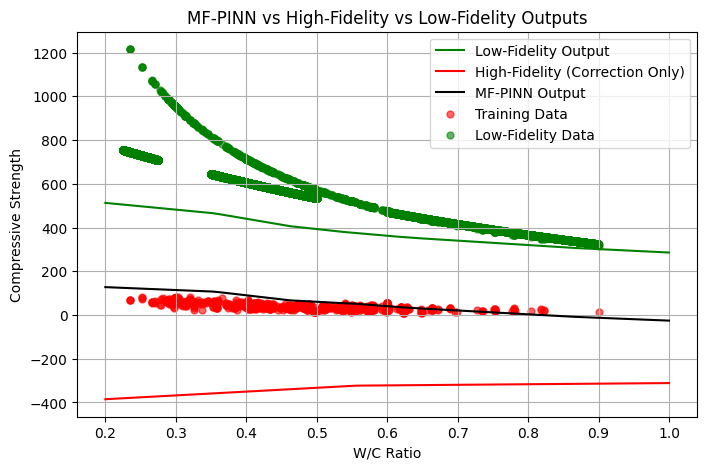

In [11]:
net_lf.eval()
net_corr.eval()

# Generate evenly spaced W/C inputs for plotting
x_plot = torch.linspace(0.2, 1, 1000).view(-1, 1).to(device)

# Get predictions from each model
with torch.no_grad():
    u_lf_plot = net_lf(x_plot).cpu().numpy()
    u_corr_plot = net_corr(x_plot).cpu().numpy()
    u_combined_plot = (net_lf(x_plot) + net_corr(x_plot)).cpu().numpy()

# Plot all results
plt.figure(figsize=(8, 5))

# Low-fidelity model (green)
plt.plot(x_plot.cpu().numpy(), u_lf_plot, label='Low-Fidelity Output', color='green')

# High-fidelity model (correction only) (red)
plt.plot(x_plot.cpu().numpy(), u_corr_plot, label='High-Fidelity (Correction Only)', color='red')

# Combined MF-PINN output (black)
plt.plot(x_plot.cpu().numpy(), u_combined_plot, label='MF-PINN Output', color='black')

# Scatter plot for Training Data (red)
plt.scatter(wc.cpu().numpy(), cs.cpu().numpy(), color='red', label='Training Data', s=25, alpha=0.6)

# Scatter plot for Low-Fidelity Data (green)
plt.scatter(wc_combined.cpu().numpy(), cs_lf_combined.cpu().numpy(), color='green', label='Low-Fidelity Data', s=25, alpha=0.6)

# Labels, limits, and legend
plt.xlabel('W/C Ratio')
plt.ylabel('Compressive Strength')
plt.title('MF-PINN vs High-Fidelity vs Low-Fidelity Outputs')
#plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.savefig("MF_PINN_vs_LF_HF.svg")
plt.show()